## Sequential testing
A common issue with classical A/B-tests, especially when you want to be able to detect small differences, is that the sample size needed can be prohibitively large. In many cases it can take several weeks, months or even years to collect enough data to conclude a test. 

*   The lower number of errors we require, the larger sample size we need.
* The smaller the difference we want to detect, the larger sample size is required.

Sequential sampling works in a very non-traditional way; instead of a fixed sample size, you choose one item (or a few) at a time, and then test your hypothesis. You can either:

* Reject the null hypothesis (H0) in favor of the alternate hypothesis (H1) and stop,
* Keep the null hypothesis and stop,
* unable to reach either conclusion with current observation and continue sampling.

### Advantage of Sequential testing over classic a/b testing


*   optimize necessary observation (sample size)
*   reduce the likelihood of error
* gives a chance to finish experiments earlier without increasing the possibility of false results

**N.B: Unlike classical fixed sample-size tests, where significance is only checked after all samples have been collected, this test will continously check for significance at every new sample and stop the test as soon as a significant result is detected, while still guaranteeing the same type-1 and type-2 errors as the fixed-samplesize test.**

## Common sequential testing algorithms
- [Evan Miller Simple Sequential A/B Testing](https://www.evanmiller.org/sequential-ab-testing.html)
- [Sequential probability ratio testing (SPRT)](https://en.wikipedia.org/wiki/Sequential_probability_ratio_test)

The Evan Miller sequential procedure for one-sided test works as follows:
* choose a sample size \(N\). [Here](https://www.evanmiller.org/ab-testing/sequential.html) is the link to define N
* Assign subjects randomly to the treatment and control, with 50% probability each.
* Track the number of incoming successes from the treatment group. Call this number \(T\).
* Track the number of incoming successes from the control group. Call this number \(C\).
* If \(T-C\) reaches \(2\sqrt{N}\), stop the test. Declare the treatment to be the winner.
* If \(T+C\) reaches \(N\), stop the test. Declare no winner.

The two-sided test is essentially the same, but with an alternate ending:
* If \(T-C\) reaches \(2.25\sqrt{N}\), stop the test. Declare the treatment to be the winner.
* If \(C-T\) reaches \(2.25\sqrt{N}\), stop the test. Declare the control to be the winner.
* If \(T+C\) reaches \(N\), stop the test. Declare no winner.

**N.B: This test completely ignores the number of failures in each group, which makes it significantly easier to implement in low-conversion settings. However**
- **If we hit the threshold without having reached statistical proof, we cannot continue the experiment.**
- **Even if preliminary evidence says that one version is terrible, we will keep losing conversions until we hit an arbitrarly pre-agreed threshold.**

### Sequential probability ratio testing (SPRT)
SPRT is based on the likelihood ratio statistic.
#### Variants of SPRT
- [Wald's(1947) sequential probability ratio test](http://en.wikipedia.org/wiki/Sequential_probability_ratio_test)
 * Wald's test uses one pair of observations at each stage and ignores tied observations and thus reduces a test of a single proportion.
- [Conditional sequential probability ratio test](http://www.jstor.org/stable/2346379?seq=1#page_scan_tab_contents)
 * used to calculate tied observations b/n two proportions. So, determining statistical significance with two distributional streams of data can be used for conditional sprt.
- [Sequential Generalized Likelihood Ratio Test](https://www.auduno.com/2014/12/25/rapid-a-b-testing-with-sequential-analysis/)
  * used to measure tied observation. Has stoping rule estimation problem.

We focus on conditional SPRT for this challenge.

General steps of conditional SPRT

1. Set statistical parameters (alpha, beta, odd ratio)
2. Calculate critical upper and lower decision boundaries a & b

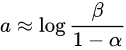    and     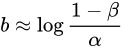
3. Then for each trail(observation) compute
 * calculate test statistics(likelihood ratio) as S
 * calculate upper and lower limits for exposed group
 * apply stopping rule


#### Stopping Rule

1. If the log probability ratio greater than or equal to the upper critical limit then the model reject the null hypothesis with the favor of alternative hypothesis (i.e. accept H1 (conclude that version two is better than version one)) and terminate the test.
  
      image.png
 
2. If the log probability ratio less than or equal to the lower critical limit then accept the null hypothesis (i.e. conclude that there is no difference between the two groups) and terminate the test.

      image.png
3. If neither critical limit is reached, conduct another trial and continue the test.

    image.png

One-sided SPRT

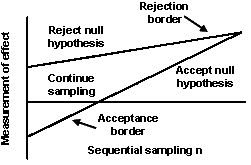

Two-sided SPRT

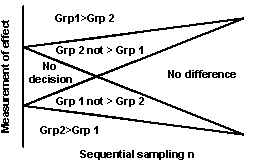

Next we will write python implementation for conditional SPRT


### Write a function to feach data.

In [2]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

In [3]:
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [166]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

### load data

In [5]:
data=pd.read_csv('../data/AdSmartABdata.csv')
data.sample(10)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
2744,589dbe6d-4d47-4841-a20f-c707326ccf3d,exposed,2020-07-06,10,Generic Smartphone,6,Chrome Mobile,1,0
474,0e1423f8-87a9-4b3e-bde3-b66a7228df4c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
4336,8a9831ce-cb3c-4f77-b471-3019f3a1f779,control,2020-07-09,23,Samsung SM-N960F,6,Chrome Mobile WebView,0,0
2732,582427c7-1aa4-4ecc-95c6-d6fdb3980a4c,exposed,2020-07-07,0,Moto $2,6,Chrome Mobile WebView,0,1
4904,9bfcdc27-dd75-4d4c-8422-bbe50a292525,control,2020-07-03,15,Samsung SM-J530F,6,Chrome Mobile WebView,0,0
6651,d2e6597d-0a21-49ec-bde7-5ad7b7c294b1,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,1
6086,c14d796d-998c-459b-a4a1-01666870eb5f,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
4924,9c6aaf93-22d4-4e04-9492-c783a2b65ffb,control,2020-07-04,5,Samsung SM-A320FL,6,Samsung Internet,0,0
3796,7a5d4370-6c7b-4d20-a274-b29c0c9f001d,control,2020-07-09,22,Generic Smartphone,6,Chrome Mobile WebView,1,0
1990,4170b5fa-c561-4ef2-9242-a92c8e4c6342,control,2020-07-04,20,Samsung SM-G970F,6,Facebook,1,0


### visualizations

In [6]:
def plot_hist(df:pd.DataFrame, column:str, color:str)->None:
    # plt.figure(figsize=(15, 10))
    # fig, ax = plt.subplots(1, figsize=(12, 7))
    sns.displot(data=df, x=column, color=color, kde=True, height=7, aspect=2)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()

def plot_bar(df:pd.DataFrame, x_col:str, y_col:str, title:str, xlabel:str, ylabel:str)->None:
    plt.figure(figsize=(12, 7))
    sns.barplot(data = df, x=x_col, y=y_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.yticks( fontsize=14)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.show()

### plot of the split between control and exposed groups

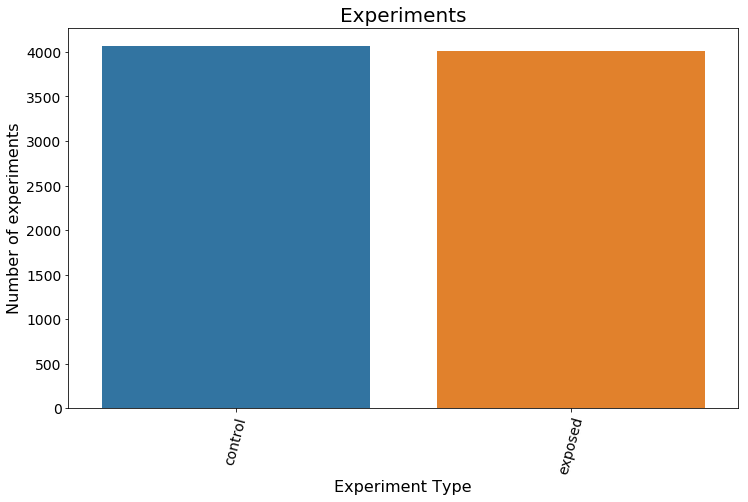

In [7]:
experiments = data[["experiment"]].groupby('experiment').agg({'experiment':'count'}).rename(columns = {'experiment' : 'count'}).reset_index()
experiments = experiments.sort_values(by="count", ascending=False)
plot_bar(experiments, 'experiment', 'count', 'Experiments', 'Experiment Type', 'Number of experiments')

### Most popular devices 

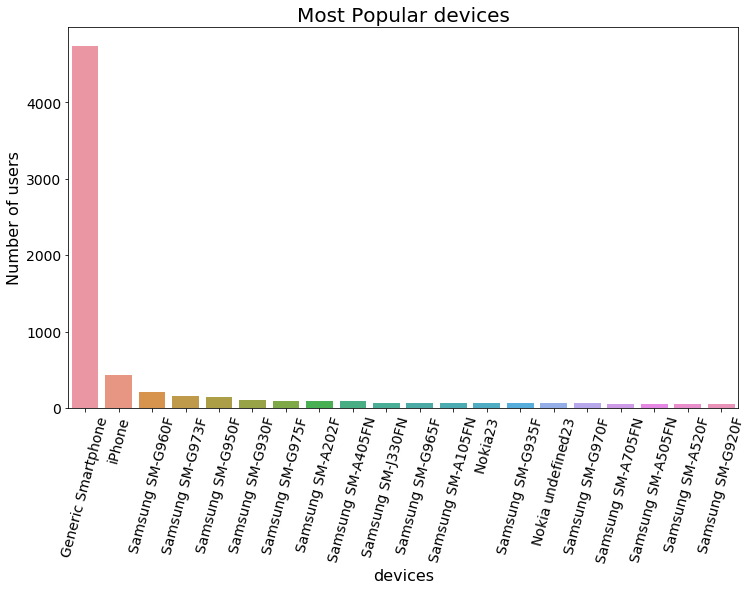

In [8]:
devices = data[["device_make"]].groupby('device_make').agg({'device_make':'count'}).rename(columns = {'device_make' : 'count'}).sort_values(by="count", ascending=False).head(20).reset_index()
devices.head()
plot_bar(devices, 'device_make', 'count', 'Most Popular devices', 'devices', 'Number of users')


### Most popular operating systems

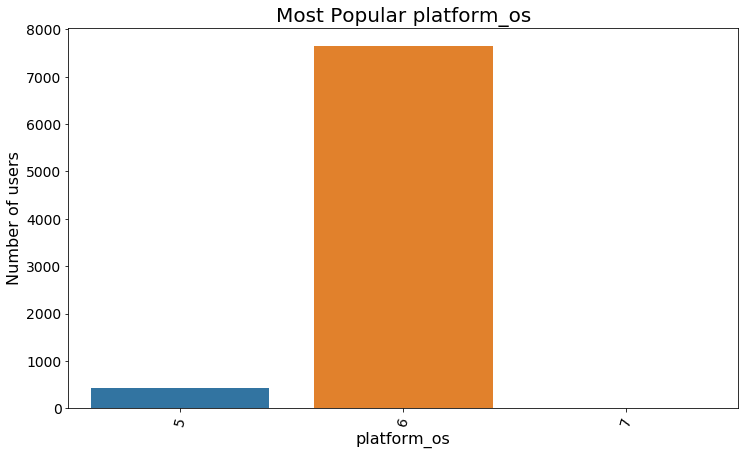

In [9]:
oss = data[["platform_os"]].groupby('platform_os').agg({'platform_os':'count'}).rename(columns = {'platform_os' : 'count'}).reset_index()
oss.head()
plot_bar(oss, 'platform_os', 'count', 'Most Popular platform_os', 'platform_os', 'Number of users')


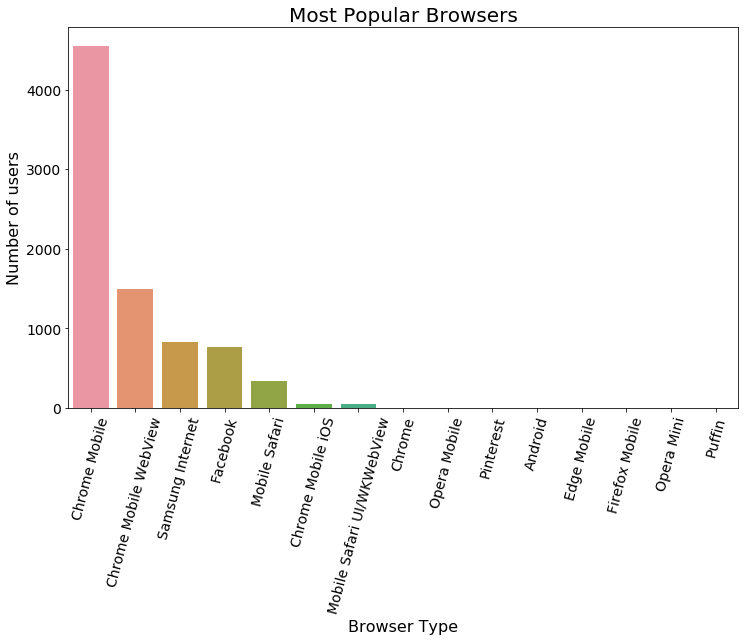

In [10]:
#plot_hist(data[["browser"]].sort_values(by="browser", ascending=False).head(1000), "browser", "blue")
browsers = data[["browser"]].groupby('browser').agg({'browser':'count'}).rename(columns = {'browser' : 'count'}).reset_index()
browsers = browsers.sort_values(by="count", ascending=False).head(20)
plot_bar(browsers, 'browser', 'count', 'Most Popular Browsers', 'Browser Type', 'Number of users')


In [11]:
data['clicked'] = data['yes'] + data['no']
data.describe()

,hour,platform_os,yes,no,clicked
count,8077.000000,8077.000000,8077.000000,8077.000000,8077.000000
mean,11.615080,5.947134,0.070818,0.083075,0.153894
std,5.734879,0.224333,0.256537,0.276013,0.360869
min,0.000000,5.000000,0.000000,0.000000,0.000000
25%,7.000000,6.000000,0.000000,0.000000,0.000000
50%,13.000000,6.000000,0.000000,0.000000,0.000000
75%,15.000000,6.000000,0.000000,0.000000,0.000000
max,23.000000,7.000000,1.000000,1.000000,1.000000


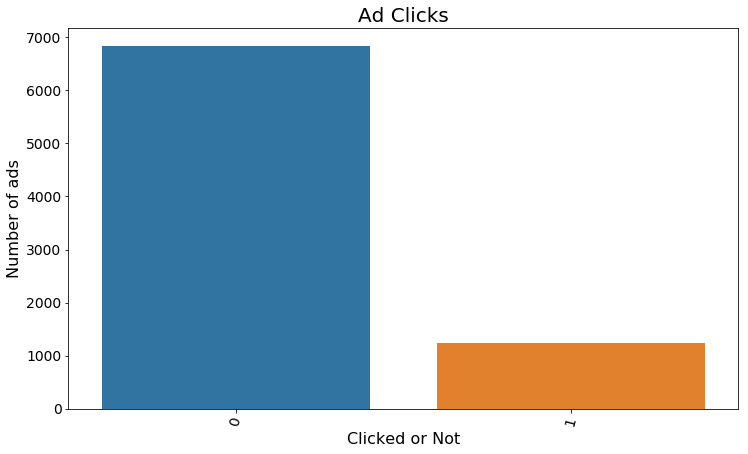

In [12]:
clicks = data[["clicked"]].groupby('clicked').agg({'clicked':'count'}).rename(columns = {'clicked' : 'count'}).reset_index()
clicks = clicks.sort_values(by="count", ascending=False)
plot_bar(clicks, 'clicked', 'count', 'Ad Clicks', 'Clicked or Not', 'Number of ads')

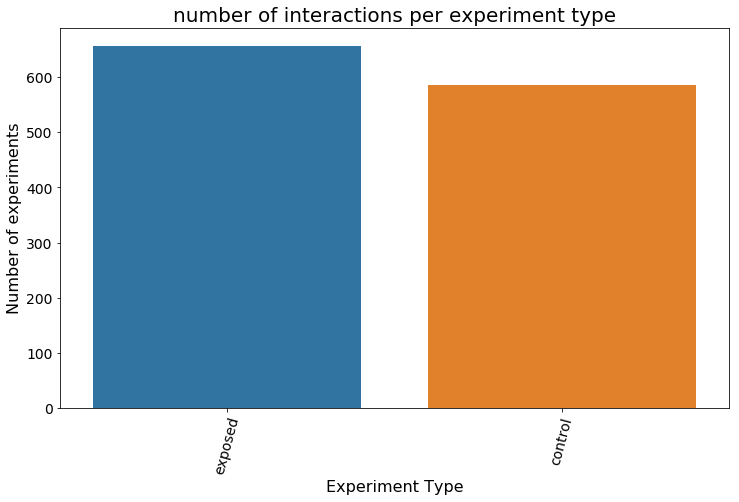

In [13]:
experiments = data[data['clicked'] == 1][["experiment"]].groupby('experiment').agg({'experiment':'count'}).rename(columns = {'experiment' : 'count'}).reset_index()
experiments = experiments.sort_values(by="count", ascending=False)
plot_bar(experiments, 'experiment', 'count', 'number of interactions per experiment type', 'Experiment Type', 'Number of experiments')

In [12]:
clicks/8077

,clicked,count
0,0.000000,0.846106
1,0.000124,0.153894


In [13]:
clicked_ads = data[data['clicked'] == 1]
clicked_ads.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no,clicked
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1,1
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0,1
20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0,1,1
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0,1
27,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,1,1


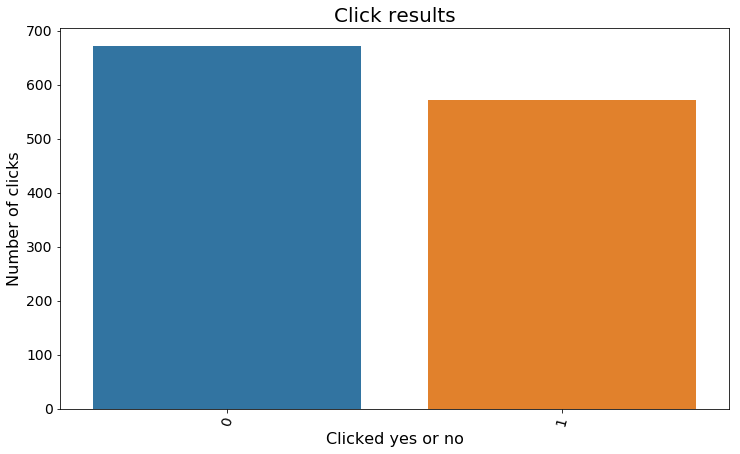

In [14]:
clicked = clicked_ads[["yes"]].groupby('yes').agg({'yes':'count'}).rename(columns = {'yes' : 'count'}).reset_index()
clicked = clicked.sort_values(by="count", ascending=False)
plot_bar(clicked, 'yes', 'count', 'Click results', 'Clicked yes or no', 'Number of clicks')

# Classical z test

## split data

In [19]:
exposed = data[data['clicked'] == 1][data['experiment'] == 'exposed']
control = data[data['clicked'] == 1][data['experiment'] == 'control']

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [20]:
exposed.sample(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no,clicked
6075,c0d68612-6d17-4522-aeac-afb99a656c3b,exposed,2020-07-08,20,Generic Smartphone,6,Chrome Mobile,1,0,1
1862,3d8f2180-0787-40a7-9566-62d16f672882,exposed,2020-07-09,4,Samsung SM-G975F,6,Chrome Mobile WebView,0,1,1
5143,a3af7c56-caf7-4ee0-bdfd-d5514dd03fbb,exposed,2020-07-08,18,Samsung SM-G950F,6,Chrome Mobile WebView,1,0,1
3730,78334283-17e0-4221-b93b-18d65beffe9b,exposed,2020-07-03,13,Generic Smartphone,6,Chrome Mobile,1,0,1
3734,78482867-0973-4aac-934d-d01454044dff,exposed,2020-07-04,15,Generic Smartphone,6,Chrome Mobile,0,1,1


In [24]:
control.sample(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no,clicked
3145,65bdd9fd-60f5-4240-b6b0-fe48e46831a3,control,2020-07-09,13,Samsung SM-G960F,6,Facebook,0,1,1
6088,c164494f-54fb-4e8f-b421-fc6b75fb783f,control,2020-07-04,10,DLI-L22,6,Facebook,0,1,1
8010,fd53005c-f3f1-4f7d-97cc-84fab926bcaa,control,2020-07-04,4,Generic Smartphone,6,Chrome Mobile,0,1,1
5176,a47fb994-f66d-4f6f-9d5e-1dc967ff24bf,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,1,0,1
1591,34abde6e-7d4c-46e5-9060-7226a5b4ff2a,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,1,0,1


In [26]:
len(exposed),len(control)

(657, 586)

## Testing

In [160]:

class ClassicalTest:
    def __init__(self, exposed, control, sample_size):
        self.exposed = np.array(exposed.sample(sample_size)['yes'])
        self.control = np.array(control.sample(sample_size)['yes'])
        self.sample_size = sample_size
        
    def z_value(self):
        e_mean = np.mean(self.exposed)
        c_mean = np.mean(self.control)
        #print("exposed mean:", e_mean, "control mean:", c_mean)
        z = (e_mean - c_mean)/(c_mean*(1-c_mean)/self.sample_size)**0.5
        return z


In [161]:
test = ClassicalTest(exposed,control, 550)
print("z-value:", test.z_value())
print("p-value:", scipy.stats.norm.sf(test.z_value()))

z-value: 1.2849602186368132
p-value: 0.09940309292844818


### Conclusion

#### since the p value is greater than 0.05, there is no statistically significant difference between two test groups

# Sequential Testing

Double click the following cell to get sample conditional SPRT code

##### Use the next class structure to complete your sequential testing

In [219]:
## your code here. include other necessary functions as you want.
import random
class SequentialTest:
    def __init__(self,exposed,control,sample_size):
        self.exposed = exposed
        self.control = control
        self.sample_size = sample_size
        
        '''
        initialise startup variables
        '''

    def stoppingRule(self, T, C):
        '''
        This function should take current observation and return statistical decision made. 
        Consider truncate rule for longer tests
        '''
        if T - C > 2*(self.sample_size)**0.5 :
            return (1, "Exposed group produced a statistically significant increase.")
        elif T + C > self.sample_size:
            return (2, "Their is no statistically significant difference between two test groups")
        else: return (0, 'more samples needed')
    
    def perform_test(self):
        random.shuffle(self.exposed)
        random.shuffle(self.control)
        self.T, self.C = 0, 0
        for i in range(self.sample_size):
            self.T += self.exposed[i]
            self.C += self.control[i]
            j, message = self.stoppingRule(self.T, self.C)
            if j == 1 or j == 2:
                return message
        return 'sample size too small'
        
    def computeBoundaries(self,):
        '''
        This function shoud compute boundaries 
        '''

    def plotTest(self,):
        '''
        showing the cumulative statistical test (e.g., log probability ratio) and the uper and lower limits.
        '''

    def plotBoundaries(self,):
        '''cumulative sums of exposed successes, bounded by the critical limits.
        '''



In [234]:
def transform_data(df, sample_size):
    '''
    segment data into exposed and control groups
    consider that SmartAd runs the experment hourly, group data into hours. 
      Hint: create new column to hold date+hour and use df.column.map(lambda x:  pd.Timestamp(x,tz=None).strftime('%Y-%m-%d:%H'))
    create two dataframes with bernouli series 1 for posetive(yes) and 0 for negative(no)
    Hint: Given engagement(sum of yes and no until current observation as an array) and success (yes countas an array), 
    the method generates random binomial distribution
        #Example
           engagement = np.array([5, 3, 3])
           yes = np.array([2, 0, 3])       
         Output is "[1] 1 0 1 0 0 0 0 0 1 1 1", showing a binary array of 5+3+3 values
         of which 2 of the first 5 are ones, 0 of the next 3 are ones, and all 3 of
         the last 3 are ones where position the ones is randomly distributed within each group.
    '''
    exposed = df[df['clicked'] == 1][df['experiment'] == 'exposed']
    control = df[df['clicked'] == 1][df['experiment'] == 'control']
    exposed = np.array(exposed.sample(sample_size)['yes'])
    control = np.array(control.sample(sample_size)['yes'])
    return exposed,control

def plotDataSummary(exposed, control):
    fig, axs = plt.subplots(1,2,figsize=(16,4))
    fig.suptitle('Yes-no distribution per group')
    sns.countplot(x = 'yes', data=pd.DataFrame({'yes' : exposed}),ax=axs[0]).set_title('Exposed Group')
    sns.countplot(x = 'yes', data=pd.DataFrame({'yes' : control}),ax=axs[1]).set_title('Control Group')
    
def pretyPrintTestResult(test):
    '''This function print final test result. Json format is recommended. For example'''
    message = test.perform_test()
    res = {
    "name": "Sequential AB Testing",
    "engagementCountControl": len(test.control),
    "engagementCountExposed": len(test.exposed),
    "positiveCountControl": test.C,
    "positiveCountExposed": test.T,
    "TotalObservation": message
    }
    return res

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


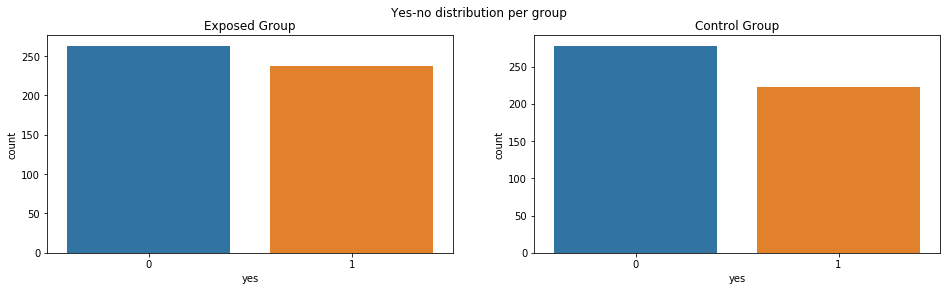

In [235]:

######################################
# 'Define statistical parameters such as alpha, beta, sample size if evan approach is used, odd ratio for SPRT'

sample_size = 500

##data processing here
exposed, control = transform_data(data, sample_size)

##plot data summary
plotDataSummary(exposed,control)


In [236]:
test=SequentialTest(exposed, control, sample_size)

'Print test result.'
pretyPrintTestResult(test)

{'name': 'Sequential AB Testing',
 'engagementCountControl': 500,
 'engagementCountExposed': 500,
 'positiveCountControl': 222,
 'positiveCountExposed': 237,
 'TotalObservation': 'sample size too small'}